In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)



In [15]:
import kagglehub

path = kagglehub.dataset_download("lantian773030/pokemonclassification")
DATA_DIR = os.path.join(path, "PokemonData")

print("Using dataset:", DATA_DIR)
classes = sorted(os.listdir(DATA_DIR))
print("Num classes:", len(classes))


100%|██████████| 417M/417M [00:19<00:00, 22.8MB/s]

Extracting files...


Using dataset: /root/.cache/kagglehub/datasets/lantian773030/pokemonclassification/versions/1/PokemonData
Num classes: 150


In [16]:
valid_ext = [".png", ".jpg", ".jpeg"]

image_paths = []
labels = []

for cls in classes:
    for img_path in glob(os.path.join(DATA_DIR, cls, "*")):
        if os.path.splitext(img_path)[1].lower() in valid_ext:
            image_paths.append(img_path)
            labels.append(cls)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total valid images:", len(image_paths))


Total valid images: 6820


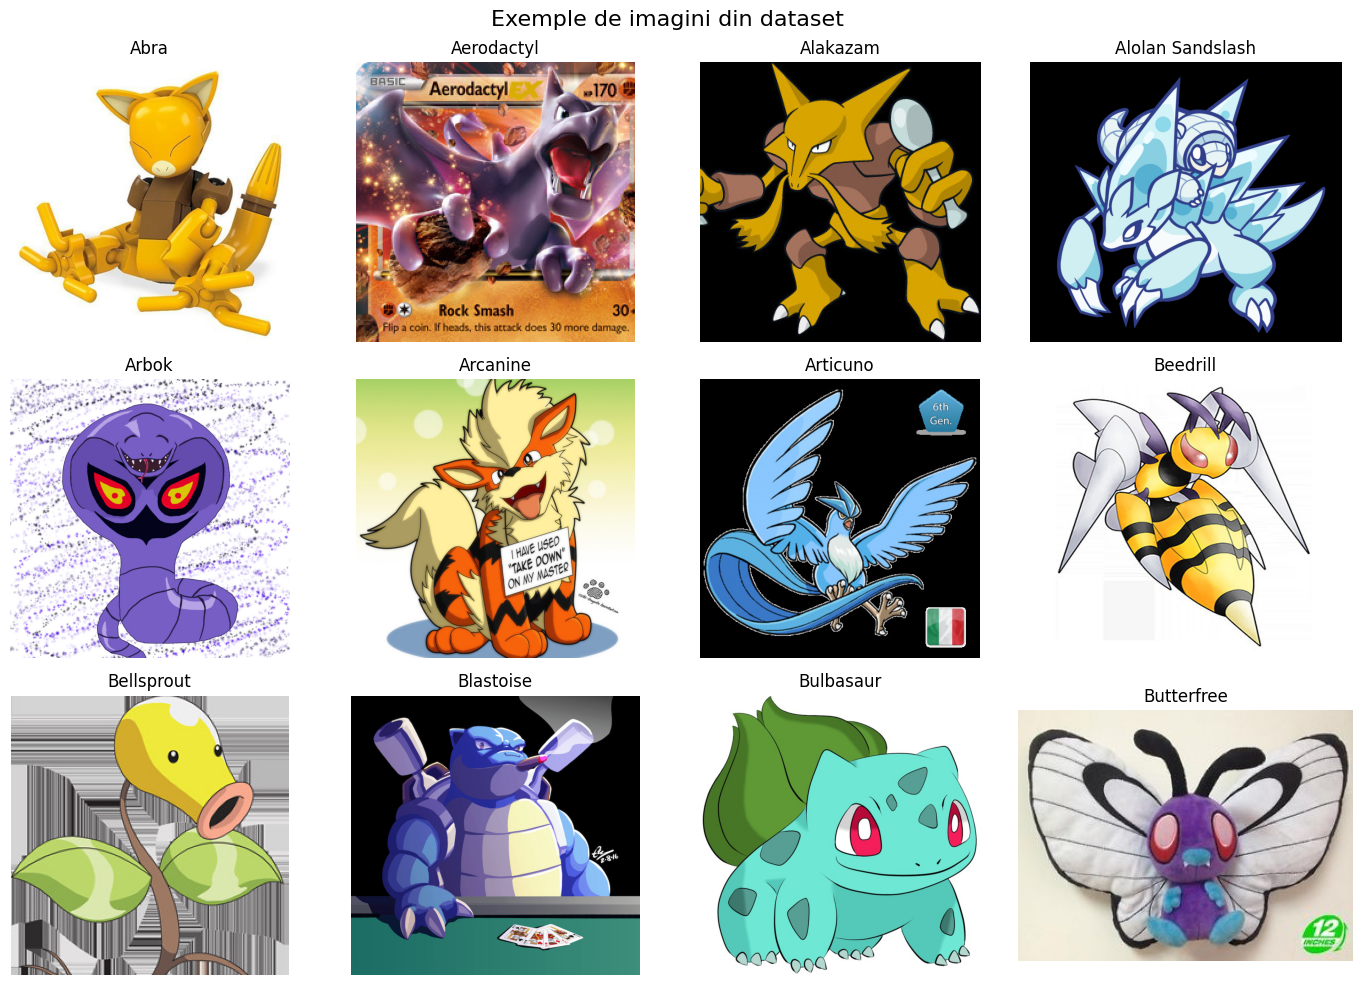

In [26]:
# =========================
# VIZUALIZARE MOSTRE IMAGINI DIN FIECARE CLASĂ
# =========================

plt.figure(figsize=(14, 10))

num_show = 12  # câte clase să arătăm
classes_to_show = classes[:num_show]

for i, cls in enumerate(classes_to_show):
    img_path = glob(os.path.join(DATA_DIR, cls, "*"))[0]  # prima imagine a clasei
    img = Image.open(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Exemple de imagini din dataset", fontsize=16)
plt.tight_layout()
plt.show()


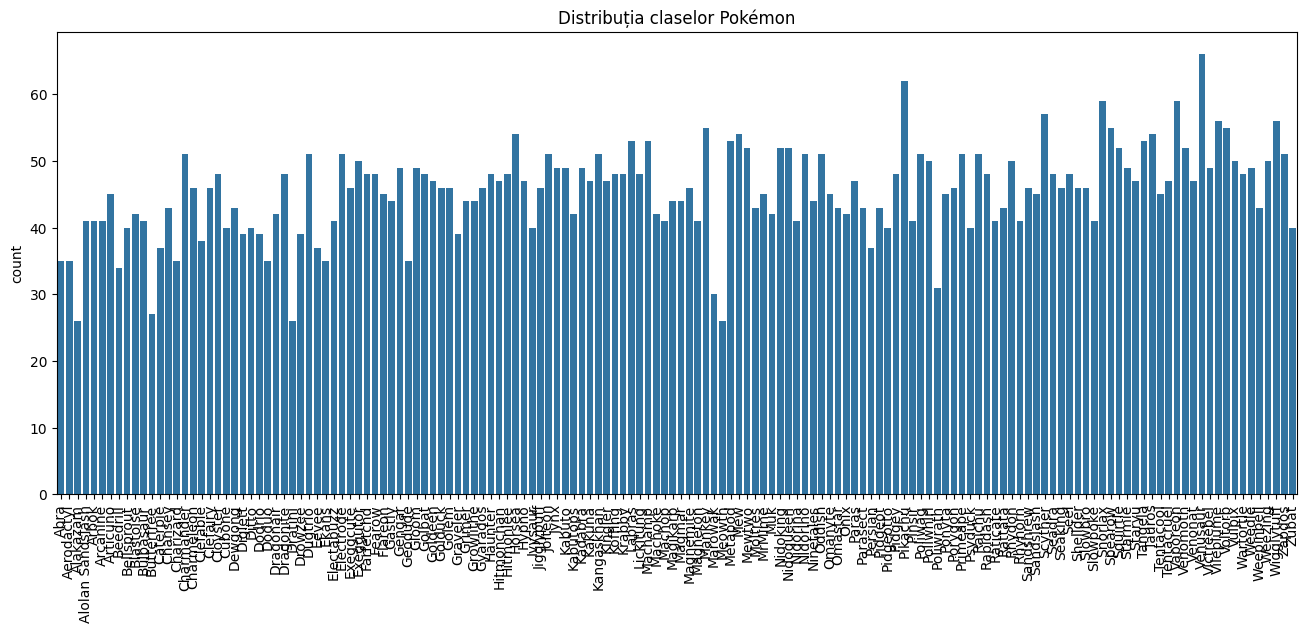

In [17]:
plt.figure(figsize=(16,6))
sns.countplot(x=labels, order=classes)
plt.xticks(rotation=90)
plt.title("Distribuția claselor Pokémon")
plt.show()


In [18]:
IMG_SIZE_ML = (32, 32)

def load_small(path):
    img = Image.open(path).convert("RGB").resize(IMG_SIZE_ML)
    return np.array(img).flatten() / 255.0

X_small = np.array([load_small(p) for p in image_paths])
y_small = labels.copy()

X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    X_small, y_small, test_size=0.2, random_state=SEED, stratify=y_small
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    random_state=SEED
)

rf.fit(X_train_ml, y_train_ml)

rf_train_pred = rf.predict(X_train_ml)
rf_val_pred   = rf.predict(X_val_ml)

rf_train_acc = accuracy_score(y_train_ml, rf_train_pred)
rf_val_acc   = accuracy_score(y_val_ml, rf_val_pred)

print("RF Train Accuracy:", rf_train_acc)
print("RF Val Accuracy:", rf_val_acc)


RF Train Accuracy: 0.9979838709677419
RF Val Accuracy: 0.31158357771260997


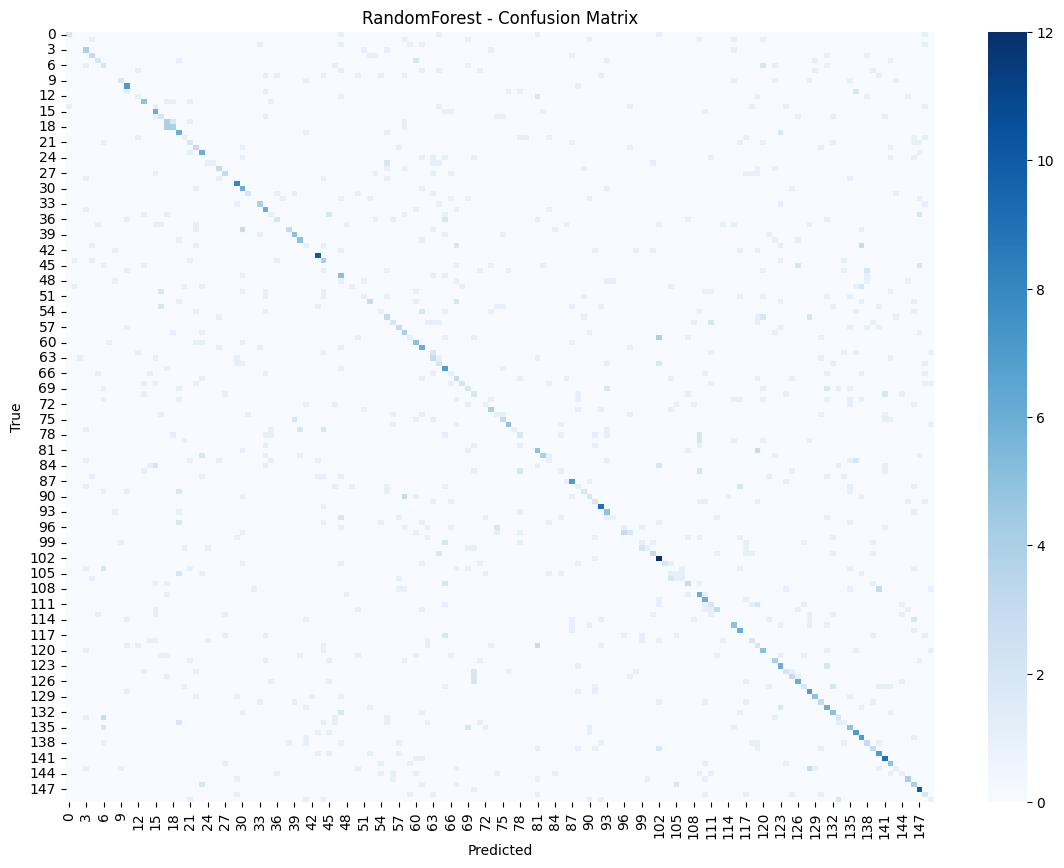

In [19]:
cm_rf = confusion_matrix(y_val_ml, rf_val_pred, labels=classes)

plt.figure(figsize=(14,10))
sns.heatmap(cm_rf, cmap="Blues")
plt.title("RandomForest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
subset = min(4000, len(X_train_ml))
X_train_svc = X_train_ml[:subset]
y_train_svc = y_train_ml[:subset]

svc = SVC(kernel="rbf", C=1.0, gamma="scale")

svc.fit(X_train_svc, y_train_svc)

svc_train_pred = svc.predict(X_train_svc)
svc_val_pred   = svc.predict(X_val_ml)

svc_train_acc = accuracy_score(y_train_svc, svc_train_pred)
svc_val_acc   = accuracy_score(y_val_ml, svc_val_pred)

print("SVC Train Accuracy:", svc_train_acc)
print("SVC Val Accuracy:", svc_val_acc)


SVC Train Accuracy: 0.71625
SVC Val Accuracy: 0.2126099706744868


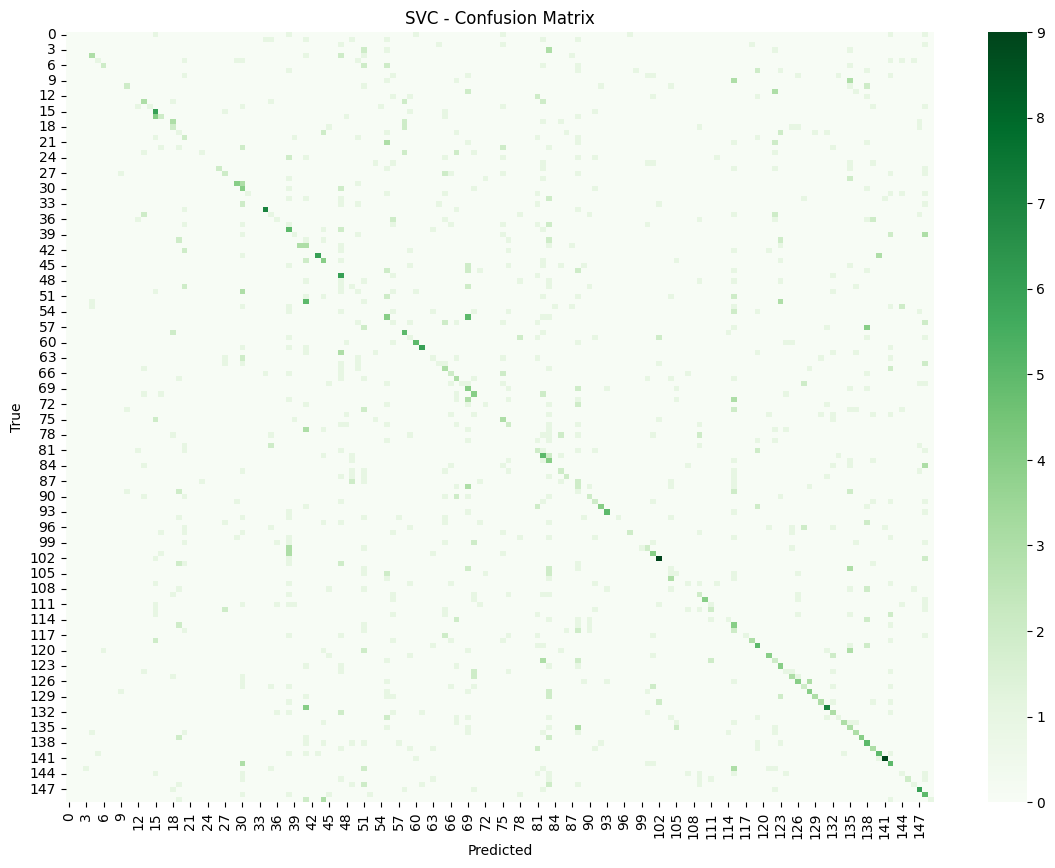

In [21]:
cm_svc = confusion_matrix(y_val_ml, svc_val_pred, labels=classes)

plt.figure(figsize=(14,10))
sns.heatmap(cm_svc, cmap="Greens")
plt.title("SVC - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [22]:
IMG_SIZE_CNN = (64, 64)
BATCH_SIZE = 32

train_cnn = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE_CNN,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    seed=SEED
)

val_cnn = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
).flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE_CNN,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=SEED
)

NUM_CLASSES = train_cnn.num_classes


Found 5511 images belonging to 150 classes.
Found 1309 images belonging to 150 classes.


In [23]:
cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE_CNN + (3,)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        38,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,311,702 (5.00 MB)

 Trainable params: 1,311,702 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_cnn = cnn.fit(
    train_cnn,
    validation_data=val_cnn,
    epochs=15,
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
173/173 - 37s - 212ms/step - accuracy: 0.0167 - loss: 4.8864 - val_accuracy: 0.0328 - val_loss: 4.4875
Epoch 2/15
173/173 - 28s - 160ms/step - accuracy: 0.0564 - loss: 4.2724 - val_accuracy: 0.1276 - val_loss: 3.7043
Epoch 3/15
173/173 - 25s - 146ms/step - accuracy: 0.1036 - loss: 3.7872 - val_accuracy: 0.2139 - val_loss: 3.2647
Epoch 4/15
173/173 - 26s - 150ms/step - accuracy: 0.1537 - loss: 3.4750 - val_accuracy: 0.2926 - val_loss: 2.8934
Epoch 5/15
173/173 - 30s - 174ms/step - accuracy: 0.1954 - loss: 3.1978 - val_accuracy: 0.3552 - val_loss: 2.6154
Epoch 6/15
173/173 - 26s - 147ms/step - accuracy: 0.2337 - loss: 2.9950 - val_accuracy: 0.3911 - val_loss: 2.4652
Epoch 7/15
173/173 - 26s - 151ms/step - accuracy: 0.2635 - loss: 2.8477 - val_accuracy: 0.3904 - val_loss: 2.3560
Epoch 8/15
173/173 - 26s - 148ms/step - accuracy: 0.2880 - loss: 2.7177 - val_accuracy: 0.4248 - val_loss: 2.2248
Epoch 9/15
173/173 - 26s - 150ms/step - accuracy: 0.3152 - loss: 2.5802 - val_accuracy: 

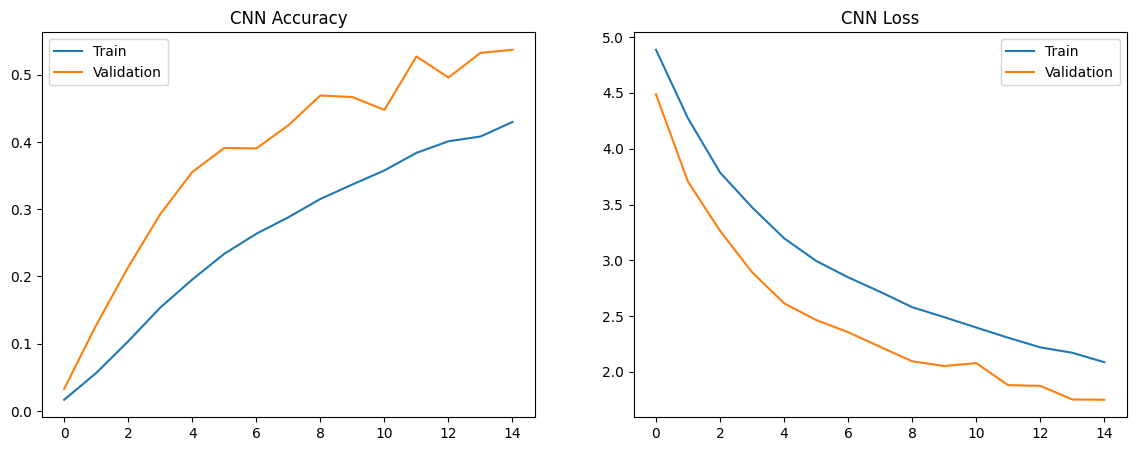

In [27]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_cnn.history["accuracy"], label="Train")
plt.plot(history_cnn.history["val_accuracy"], label="Validation")
plt.title("CNN Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history["loss"], label="Train")
plt.plot(history_cnn.history["val_loss"], label="Validation")
plt.title("CNN Loss")
plt.legend()

plt.show()


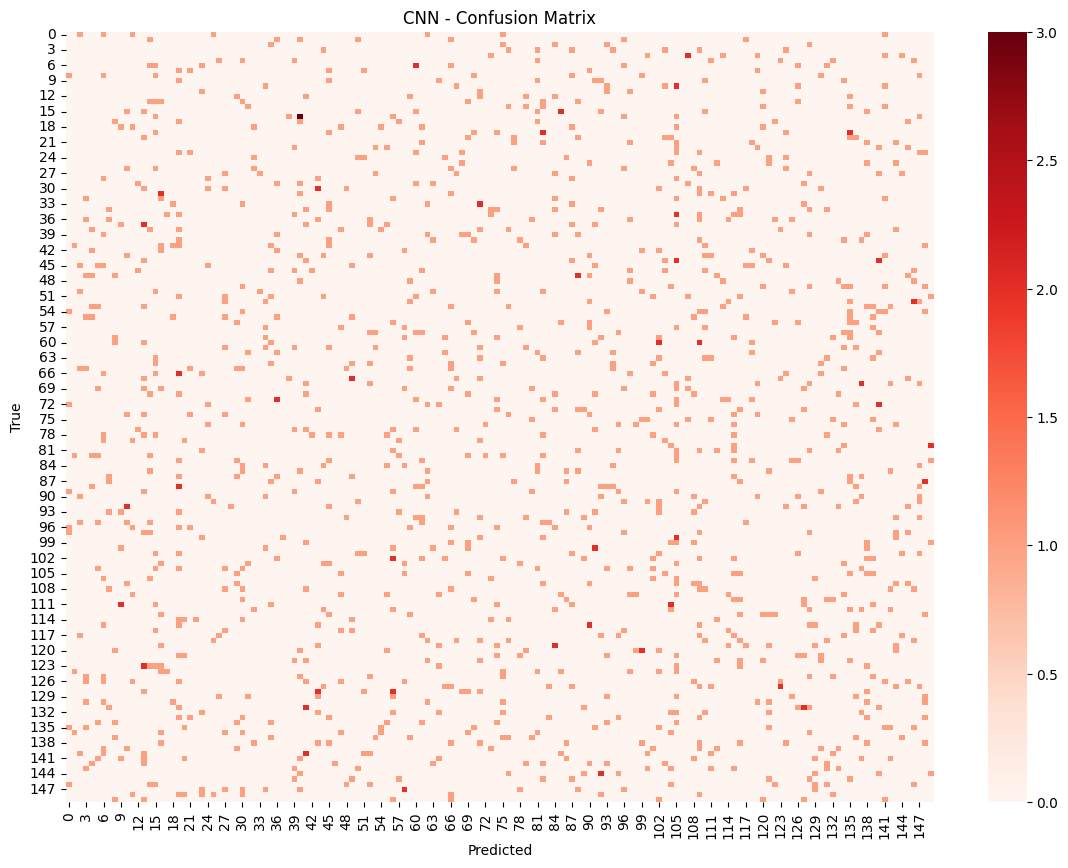

In [28]:
val_cnn.reset()
preds_cnn = cnn.predict(val_cnn, verbose=0)
pred_labels_cnn = np.argmax(preds_cnn, axis=1)
true_labels_cnn = val_cnn.classes

cm_cnn = confusion_matrix(true_labels_cnn, pred_labels_cnn)

plt.figure(figsize=(14,10))
sns.heatmap(cm_cnn, cmap="Reds")
plt.title("CNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cnn_val_acc = history_cnn.history["val_accuracy"][-1]


In [29]:
IMG_SIZE_TL = (160, 160)

train_tl = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
).flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE_TL,
    class_mode="categorical",
    batch_size=32,
    subset="training",
    seed=SEED
)

val_tl = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
).flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE_TL,
    class_mode="categorical",
    batch_size=32,
    subset="validation",
    seed=SEED
)


Found 5511 images belonging to 150 classes.
Found 1309 images belonging to 150 classes.


In [30]:
base = MobileNetV2(include_top=False, input_shape=IMG_SIZE_TL + (3,), weights="imagenet")
base.trainable = False

model_tl = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_tl.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │       192,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,450,134 (9.35 MB)

 Trainable params: 192,150 (750.59 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
history_tl_1 = model_tl.fit(
    train_tl,
    validation_data=val_tl,
    epochs=5,
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
173/173 - 94s - 544ms/step - accuracy: 0.2241 - loss: 3.7959 - val_accuracy: 0.5210 - val_loss: 2.2110
Epoch 2/5
173/173 - 51s - 294ms/step - accuracy: 0.6146 - loss: 1.5882 - val_accuracy: 0.6303 - val_loss: 1.5995
Epoch 3/5
173/173 - 50s - 291ms/step - accuracy: 0.7432 - loss: 1.0372 - val_accuracy: 0.6822 - val_loss: 1.3535
Epoch 4/5
173/173 - 51s - 296ms/step - accuracy: 0.8044 - loss: 0.7754 - val_accuracy: 0.7005 - val_loss: 1.2426
Epoch 5/5
173/173 - 51s - 292ms/step - accuracy: 0.8452 - loss: 0.6395 - val_accuracy: 0.7166 - val_loss: 1.1811


In [32]:
base.trainable = True

for layer in base.layers[:-30]:
    layer.trainable = False

model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

history_tl_2 = model_tl.fit(
    train_tl,
    validation_data=val_tl,
    epochs=10,
    verbose=2
)


Epoch 1/10
173/173 - 83s - 480ms/step - accuracy: 0.8064 - loss: 0.7772 - val_accuracy: 0.7464 - val_loss: 0.9984
Epoch 2/10
173/173 - 51s - 294ms/step - accuracy: 0.9067 - loss: 0.3783 - val_accuracy: 0.7785 - val_loss: 0.8844
Epoch 3/10
173/173 - 51s - 292ms/step - accuracy: 0.9432 - loss: 0.2598 - val_accuracy: 0.7723 - val_loss: 0.8649
Epoch 4/10
173/173 - 51s - 297ms/step - accuracy: 0.9512 - loss: 0.2066 - val_accuracy: 0.7892 - val_loss: 0.8071
Epoch 5/10
173/173 - 50s - 292ms/step - accuracy: 0.9626 - loss: 0.1599 - val_accuracy: 0.8075 - val_loss: 0.7317
Epoch 6/10
173/173 - 51s - 292ms/step - accuracy: 0.9695 - loss: 0.1315 - val_accuracy: 0.8220 - val_loss: 0.6865
Epoch 7/10
173/173 - 51s - 292ms/step - accuracy: 0.9780 - loss: 0.1077 - val_accuracy: 0.8319 - val_loss: 0.6640
Epoch 8/10
173/173 - 51s - 294ms/step - accuracy: 0.9829 - loss: 0.0880 - val_accuracy: 0.8449 - val_loss: 0.6204
Epoch 9/10
173/173 - 51s - 294ms/step - accuracy: 0.9822 - loss: 0.0841 - val_accuracy: 

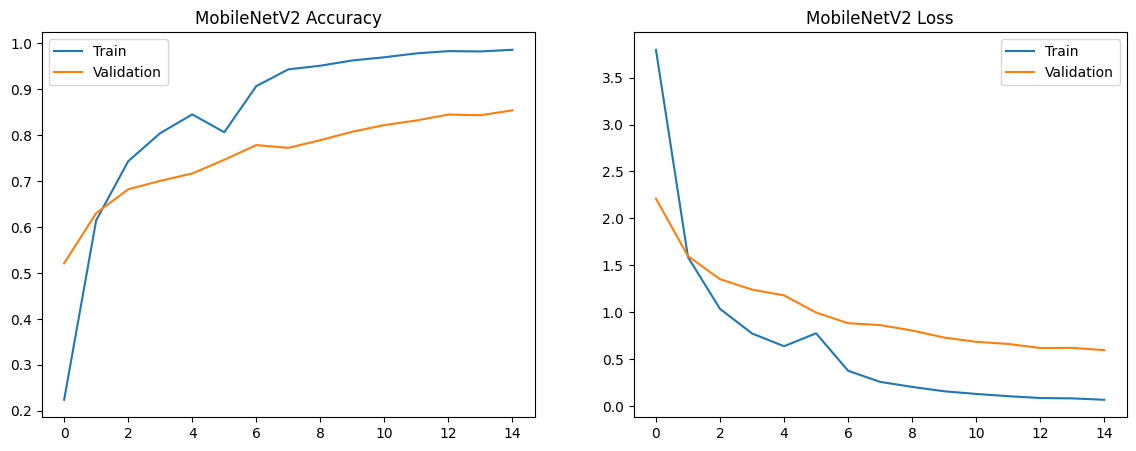

In [33]:
acc = history_tl_1.history["accuracy"] + history_tl_2.history["accuracy"]
val_acc = history_tl_1.history["val_accuracy"] + history_tl_2.history["val_accuracy"]

loss = history_tl_1.history["loss"] + history_tl_2.history["loss"]
val_loss = history_tl_1.history["val_loss"] + history_tl_2.history["val_loss"]

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.title("MobileNetV2 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.title("MobileNetV2 Loss")
plt.legend()

plt.show()


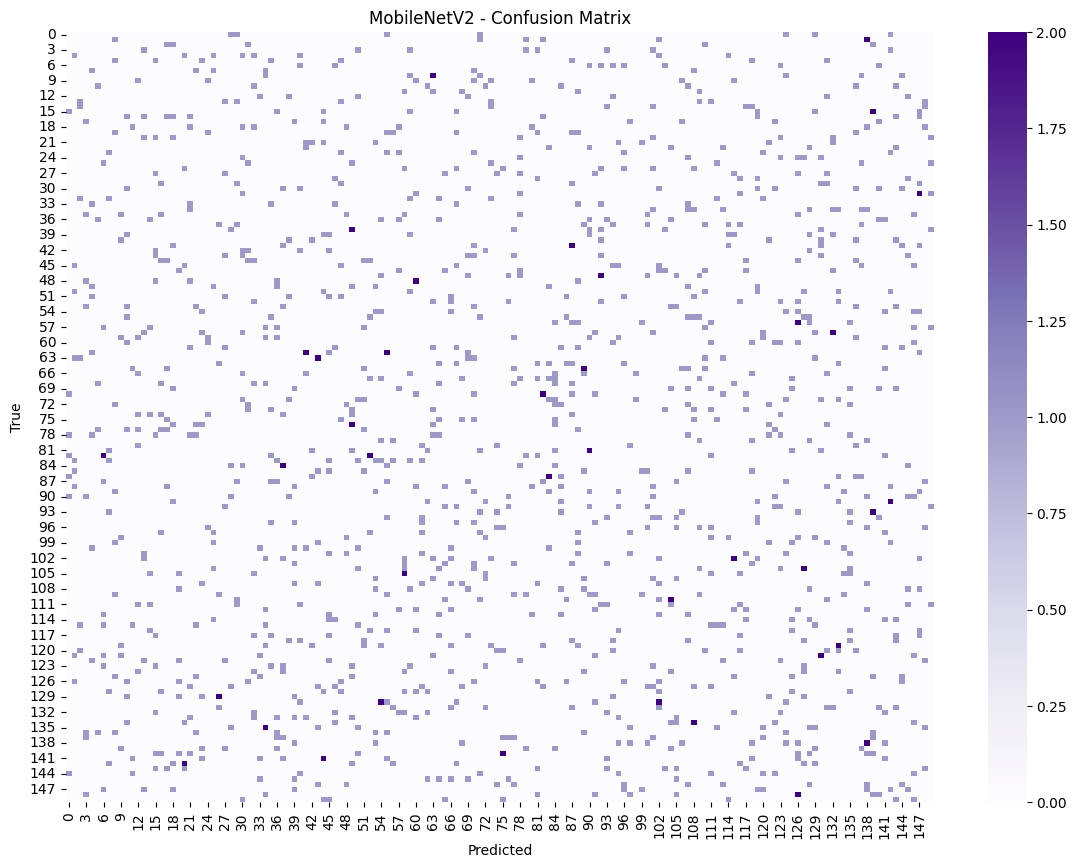

In [34]:
val_tl.reset()
preds_tl = model_tl.predict(val_tl, verbose=0)
pred_labels_tl = np.argmax(preds_tl, axis=1)
true_labels_tl = val_tl.classes

cm_tl = confusion_matrix(true_labels_tl, pred_labels_tl)

plt.figure(figsize=(14,10))
sns.heatmap(cm_tl, cmap="Purples")
plt.title("MobileNetV2 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

tl_val_acc = val_acc[-1]   # final validation accuracy


/tmp/ipython-input-489715807.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=acc_values, palette="viridis")


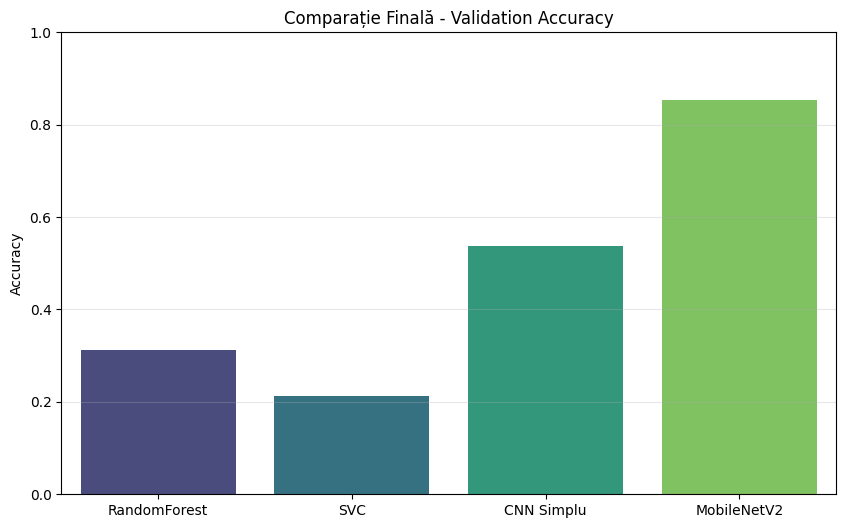

In [35]:
plt.figure(figsize=(10,6))

models = ["RandomForest", "SVC", "CNN Simplu", "MobileNetV2"]
acc_values = [rf_val_acc, svc_val_acc, cnn_val_acc, tl_val_acc]

sns.barplot(x=models, y=acc_values, palette="viridis")
plt.ylim(0,1)
plt.title("Comparație Finală - Validation Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis="y", alpha=0.3)
plt.show()
